In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import pickle
from scipy.optimize import curve_fit

## Virtualization
import matplotlib.pyplot as plt
import seaborn as sns

## res settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 10

## Clustering
from sklearn.mixture import GaussianMixture

RANDOM_STATE = 4000
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_pickle("data/train_sc.data")
data.head()

,Lithology,Porosity,Formation Resistivity Factor,EQI
0,carbonate,0.265580,50.247750,0.273743
1,carbonate,0.135722,339.767716,0.147260
2,carbonate,0.201896,109.309208,0.212867
3,carbonate,0.153623,172.815822,0.194080
4,carbonate,0.170026,158.653403,0.192538


In [3]:
data = data[data['Lithology'] == 'sandstone']
data.describe()

,Porosity,Formation Resistivity Factor,EQI
count,1311.000000,1311.000000,1311.000000
mean,0.096697,118.156360,0.370098
std,0.033492,99.099424,0.105245
min,0.037732,8.650383,0.170489
25%,0.074273,48.798225,0.281944
50%,0.087794,92.839882,0.349013
75%,0.111470,156.650674,0.451269
max,0.279581,743.425908,0.697036


In [4]:
x= np.c_[data.values,np.ones(len(data))]

In [5]:
def modelGenerator(max_, eqi_array):
    n_components = np.arange(2, max_)
    models = [np.array(GaussianMixture(n, covariance_type='tied', random_state=RANDOM_STATE).fit_predict(eqi_array.reshape(-1, 1)))
              for n in n_components]
    return models

In [6]:
def power_law(x, a, m):
    return a*np.power(x, m)

def values_and_rquared(model_predictions, mask, x):
    absError = model_predictions - x[mask, :][:,2]
    Rsquared = 1.0 - (np.var(absError) / np.var(x[mask, :][:,2]))
    return Rsquared

def modelGenerator(max_, eqi_array):
    n_components = np.arange(2, max_)
    models = [np.array(GaussianMixture(n, covariance_type='tied', random_state=RANDOM_STATE).fit_predict(eqi_array.reshape(-1, 1)))
              for n in n_components]
    return models

def variance_calculator(models, x):
    m_variances = []
    r2_variances = []
    m_parameters = []
    r2_parameters = []
    for j in range(0, len(models)):
        
        n = len(np.unique(models[j]))
        m_var = 0
        r2_var = 0 
        m_parameters[:] = []
        r2_parameters[:] = []
        x[:,4] = models[j]
        no_regression = 0
        for i in np.unique(models[j]):
            
            mask = x[:, 4] == i
            if (not (len(x[mask, :]) <= 2)):
                
                popt, _ = curve_fit(power_law, x[mask, :][:,1], x[mask, :][:,2])
                # summarize the parameter values
                a, m = popt
                m_parameters.append(abs(m))
                modelPredictions = power_law(x[mask, :][:,1], a, m)
                r2_parameters.append(values_and_rquared(modelPredictions, mask, x))
                
            else:
                no_regression += 1
                continue
        
        m_var = np.var(m_parameters)
        r2_var = np.var(r2_parameters)
        m_variances.append(m_var)
        r2_variances.append(r2_var)
        print('For ', n, ' ERTs, the m var is ', m_var, ' and the R2 var is ', r2_var,
              ' and has ', no_regression, ' ERT(s) containing less than 3 members' )
        if (m_var <= 0.001 and r2_var <= 0.001):
            print('Optimum number of clusters is ', n)
            break
    return [m_variances, r2_variances]

In [7]:
%%time
models = modelGenerator(100, x[:,3])
[mVariances, r2Variances] = variance_calculator(models, x)

For  2  ERTs, the m var is  0.028534023091667117  and the R2 var is  0.025939623394987704  and has  0  ERT(s) containing less than 3 members
For  3  ERTs, the m var is  0.05564326197023047  and the R2 var is  0.013686507880176889  and has  0  ERT(s) containing less than 3 members
For  4  ERTs, the m var is  0.17954972365521962  and the R2 var is  0.0044224377584211804  and has  0  ERT(s) containing less than 3 members
For  5  ERTs, the m var is  0.06822927872003613  and the R2 var is  0.012727307811100047  and has  0  ERT(s) containing less than 3 members
For  6  ERTs, the m var is  0.03287809059685263  and the R2 var is  0.005665305534329891  and has  0  ERT(s) containing less than 3 members
For  7  ERTs, the m var is  0.03955224297304504  and the R2 var is  0.006641851042925764  and has  0  ERT(s) containing less than 3 members
For  8  ERTs, the m var is  0.025361580645365388  and the R2 var is  0.004984205278680489  and has  0  ERT(s) containing less than 3 members
For  9  ERTs, the

For  62  ERTs, the m var is  0.0012312638810594585  and the R2 var is  0.0006204174162828818  and has  0  ERT(s) containing less than 3 members
For  63  ERTs, the m var is  0.0012134169369312098  and the R2 var is  0.0006124056665461824  and has  0  ERT(s) containing less than 3 members
For  65  ERTs, the m var is  0.0009909339955198075  and the R2 var is  0.0009524255853728964  and has  1  ERT(s) containing less than 3 members
Optimum number of clusters is  65
Wall time: 12.2 s


In [8]:
def testModel(data, n):
    _R2s = []
    _ms=[]
    _as=[]
    cl_model = GaussianMixture(n_components = n, covariance_type='tied', random_state=RANDOM_STATE)
    clusters= cl_model.fit_predict(data['EQI'].values.reshape(-1, 1))
    data['ERTs'] = clusters + 1
    sub_df = data[data.groupby('ERTs').ERTs.transform('count')>2].copy()
    withdrewnERT = data[data.groupby('ERTs').ERTs.transform('count') <= 2]
    for i in np.sort(pd.unique(sub_df['ERTs'])):
        popt, _ = curve_fit(power_law, sub_df[sub_df['ERTs'] == i]['Porosity'],  sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor'])
        # summarize the parameter values
        a, b = popt
        _ms.append(b)
        _as.append(a)
        model_predictions = power_law(sub_df[sub_df['ERTs'] == i]['Porosity'], a,b)
        absError = model_predictions - sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor']
        Rsquared = 1.0 - (np.var(absError) / np.var(sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor']))
        _R2s.append(Rsquared)
        print('ERT ', i, ': F = %.5f * φ ^ %.5f' % (a, b))
        print('R-squared:', Rsquared)
    
    print(data.groupby('ERTs').describe()[['EQI']])
    if len(withdrewnERT) == 0:
        print('There is no clusters with less than 3 components')
    else:
        print('clusters with less than 3 samples: \n',withdrewnERT['ERTs'])
        
    return [_as, _ms, _R2s, sub_df]

In [9]:
_as, _ms, _R2s, sub_df = testModel(data, 65)

ERT  1 : F = 11.75528 * φ ^ -1.02661
R-squared: 0.9809142101933805
ERT  2 : F = 4.01196 * φ ^ -0.99572
R-squared: 0.9992471800772054
ERT  3 : F = 6.45876 * φ ^ -1.00267
R-squared: 0.9998427726731212
ERT  4 : F = 2.86895 * φ ^ -1.01447
R-squared: 0.9977093703947376
ERT  5 : F = 21.06183 * φ ^ -1.05413
R-squared: 0.9674178032319369
ERT  6 : F = 8.92951 * φ ^ -0.98594
R-squared: 0.9990623014185211
ERT  7 : F = 5.04441 * φ ^ -0.99754
R-squared: 0.9992605746899106
ERT  8 : F = 19.54361 * φ ^ -0.94146
R-squared: 0.9684822550290202
ERT  9 : F = 10.63033 * φ ^ -0.99142
R-squared: 0.9930662673162909
ERT  10 : F = 2.65364 * φ ^ -0.97055
R-squared: 0.9935442853427551
ERT  11 : F = 3.70127 * φ ^ -0.94437
R-squared: 0.9961795922757967
ERT  12 : F = 5.98894 * φ ^ -0.99700
R-squared: 0.9987249000267577
ERT  13 : F = 4.54484 * φ ^ -1.00184
R-squared: 0.9992323977091939
ERT  14 : F = 7.51709 * φ ^ -0.99651
R-squared: 0.9981994641523619
ERT  15 : F = 3.70276 * φ ^ -0.99575
R-squared: 0.9987434149751663


In [10]:
def plotFvsPhi(sub_df, n, _ms, _as):
    mpl.rcParams['figure.dpi']= 700
    sns.set_palette(sns.color_palette("BrBG", n))
    for count, i in enumerate(list(np.sort(pd.unique(sub_df['ERTs'])))):
        sns.lineplot(x=sub_df[sub_df['ERTs'] == i]['Porosity'], y= _as[count] * sub_df[sub_df['ERTs'] == i]['Porosity'] ** (_ms[count]),
                    linestyle='--')  #, marker='o'
        sns.scatterplot(x=sub_df[sub_df['ERTs'] == i]['Porosity'], y= sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor'],
                            linewidths=2, edgecolor='black', label = str(i)) 
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='upper left',
               ncol=4, mode="expand")
    plt.xlabel('Porosity')
    plt.ylabel('Formation Resistivity Factor')
    plt.show()


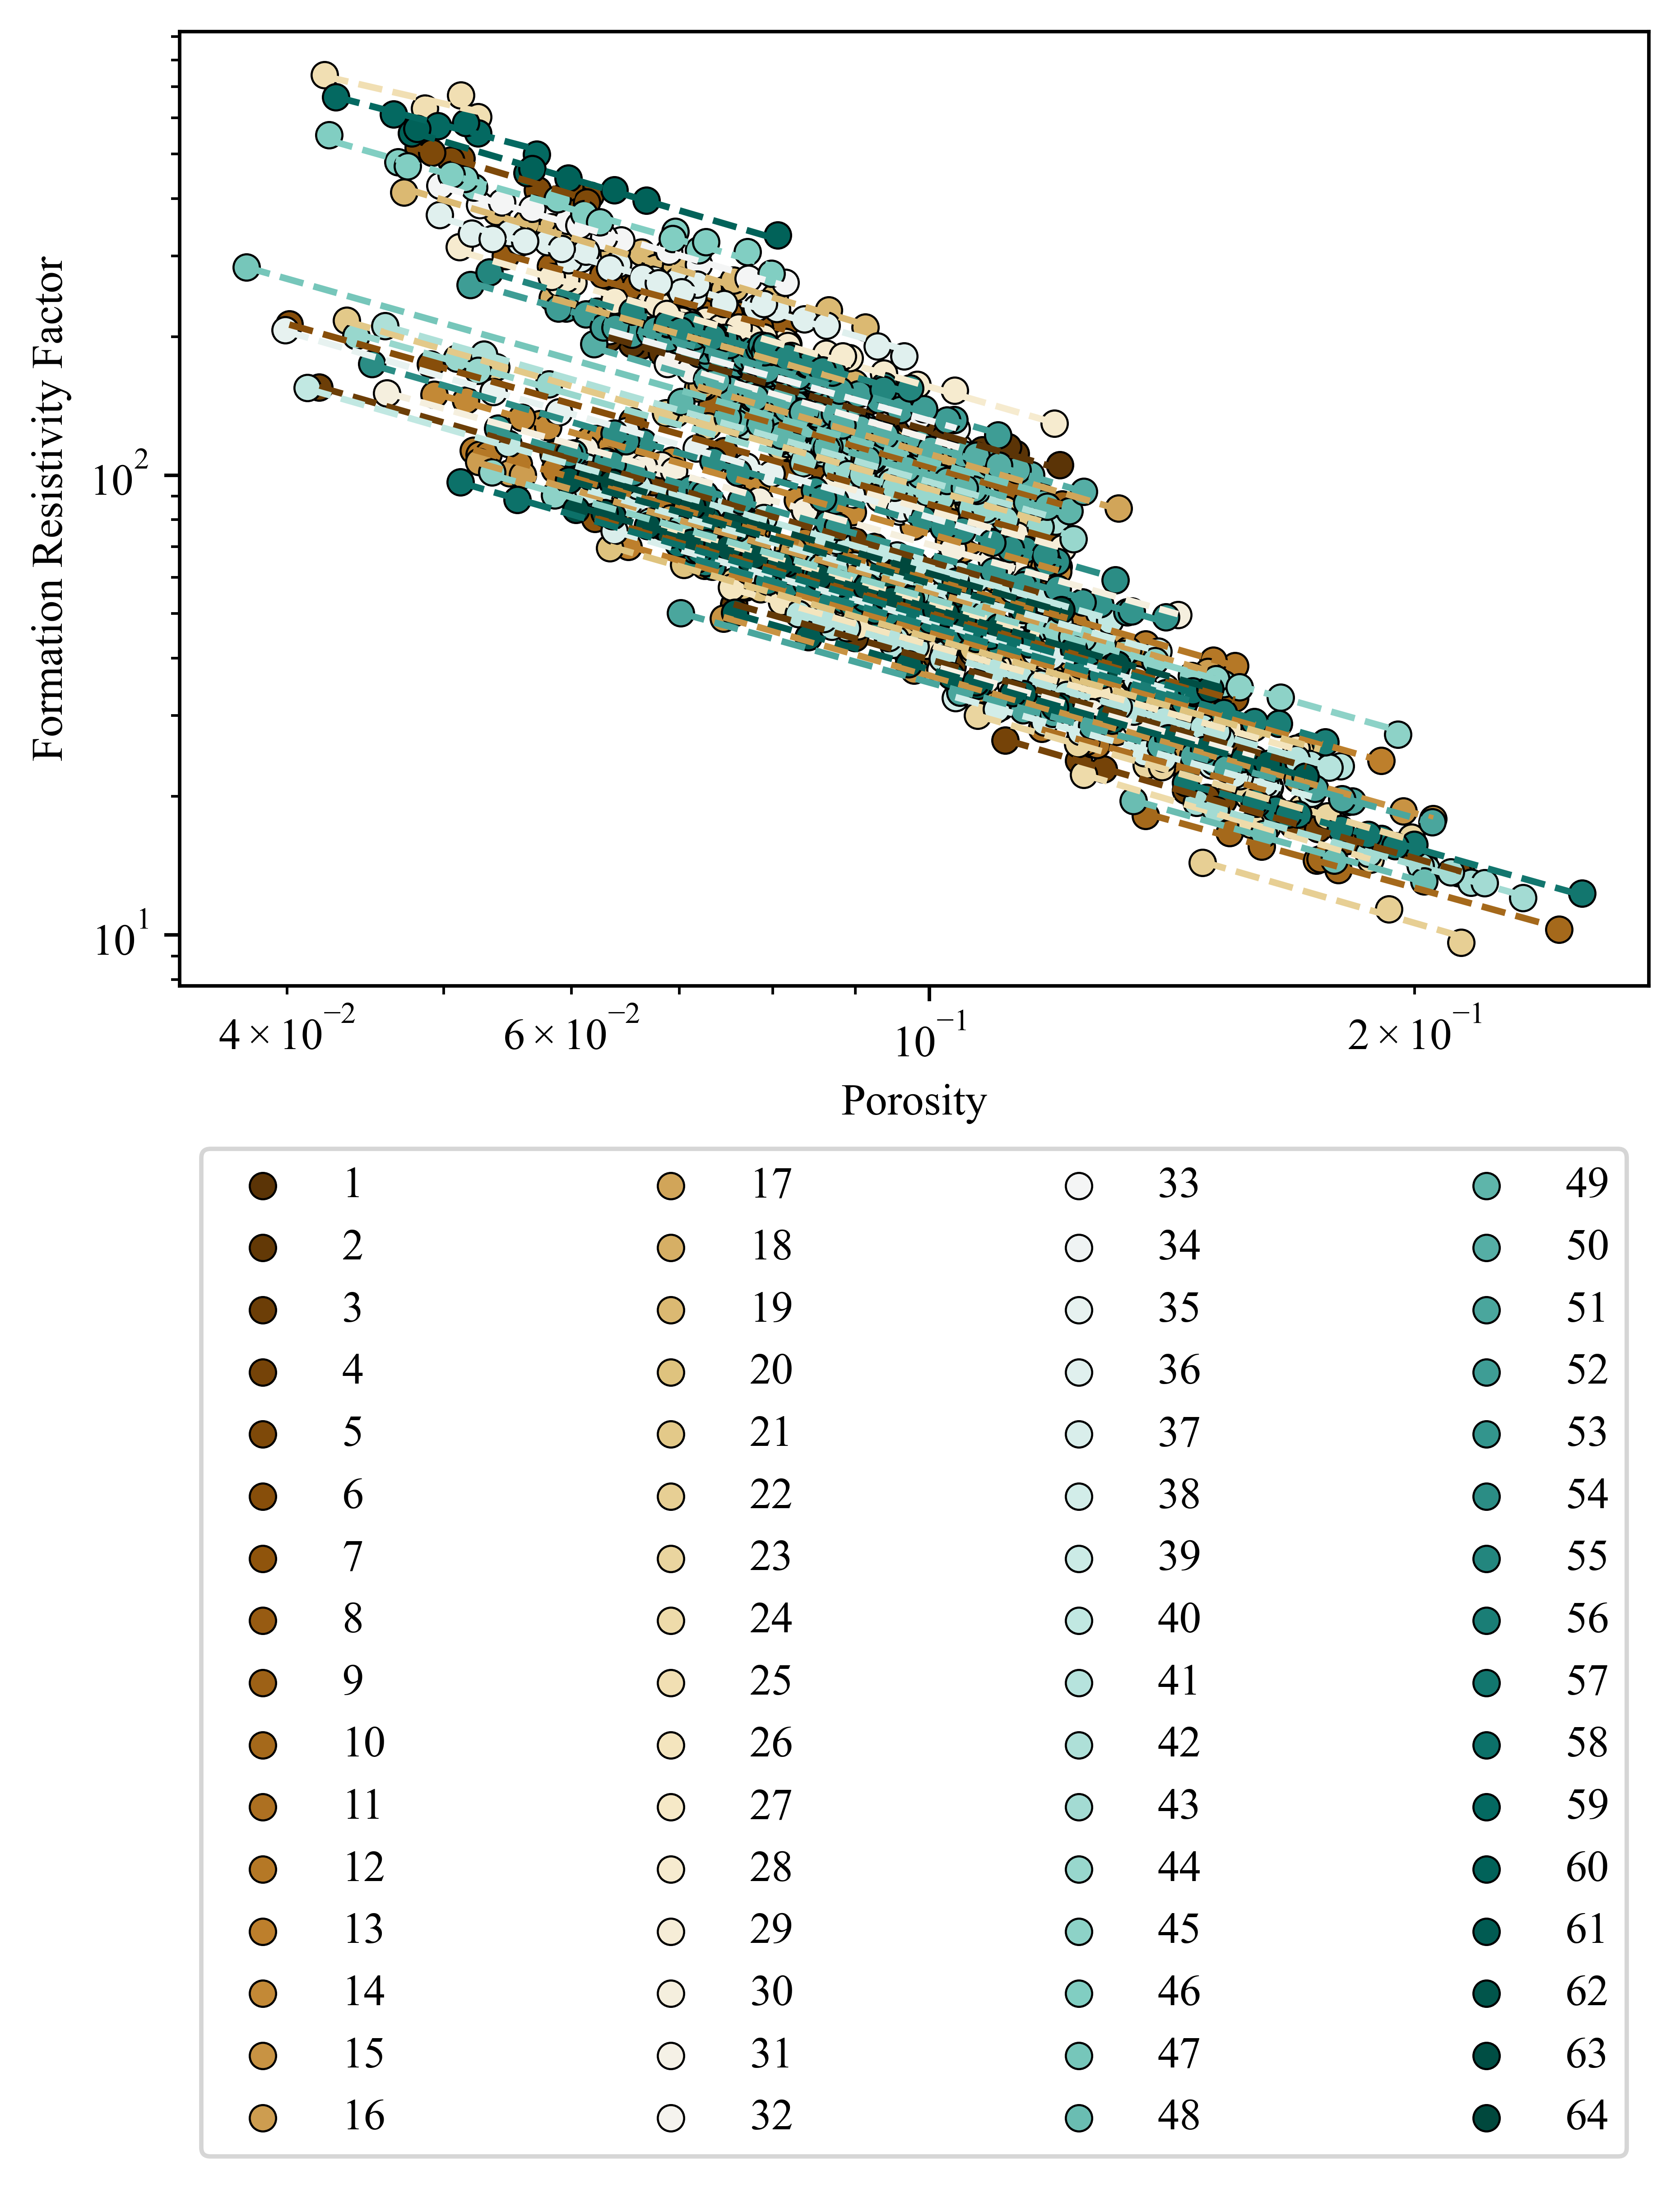

In [11]:
plotFvsPhi(sub_df, 65, _ms, _as)

In [12]:
result = {'ERT': list(np.sort(pd.unique(sub_df['ERTs']))),
        'total': list(sub_df.groupby('ERTs').count()['EQI']),
        'min': list(sub_df.groupby('ERTs').describe()['EQI']['min'].T),
        'max': list(sub_df.groupby('ERTs').describe()['EQI']['max'].T),
        'a': _as,
        'm': _ms,
        'r2': _R2s,
       }

resultsDf = pd.DataFrame(result)
resultsDf

,ERT,total,min,max,a,m,r2
0,1,72,0.277497,0.287015,11.755282,-1.026612,0.980914
1,2,15,0.497661,0.504308,4.011956,-0.995719,0.999247
2,3,9,0.390636,0.393459,6.458755,-1.002671,0.999843
3,4,15,0.576974,0.588257,2.868945,-1.014466,0.997709
4,5,9,0.198362,0.204677,21.061827,-1.054129,0.967418
5,6,26,0.336478,0.344336,8.929508,-0.985940,0.999062
6,7,19,0.444411,0.448300,5.044413,-0.997545,0.999261
7,8,27,0.239965,0.247686,19.543608,-0.941458,0.968482
8,9,25,0.307573,0.312857,10.630334,-0.991421,0.993066
9,10,7,0.625133,0.635639,2.653640,-0.970549,0.993544


In [13]:
sub_df['m'] = - (np.log10(sub_df['Formation Resistivity Factor']) / np.log10(sub_df['Porosity']))

In [25]:
def linear(x, a, b):
    return a * x + b
def mVsPhiRelation(sub_df): 
    _R2s = []
    _bs=[]
    _as=[]
    for i in np.sort(pd.unique(sub_df['ERTs'])):
        popt, _ = curve_fit(linear, sub_df[sub_df['ERTs'] == i]['Porosity'],  sub_df[sub_df['ERTs'] == i]['m'])
        # summarize the parameter values
        a, b = popt
        _bs.append(b)
        _as.append(a)
        modelPredictions = linear(sub_df[sub_df['ERTs'] == i]['Porosity'], a,b)
        absError = modelPredictions - sub_df[sub_df['ERTs'] == i]['m']
        Rsquared = 1.0 - (np.var(absError) / np.var(sub_df[sub_df['ERTs'] == i]['m']))
        _R2s.append(Rsquared)
        print('ERT ', i, ': m = %.5f * φ + %.5f' % (a, b))
        print('R-squared:', Rsquared)
    return [np.sort(pd.unique(sub_df['ERTs'])) ,_as, _bs, _R2s]

In [26]:
ERT, _as2, _bs, _R2s2 = mVsPhiRelation(sub_df)

ERT  1 : m = 4.76124 * φ + 1.62082
R-squared: 0.981240501978321
ERT  2 : m = 2.56466 * φ + 1.34231
R-squared: 0.9970069356156702
ERT  3 : m = 3.71007 * φ + 1.44165
R-squared: 0.9984989205247082
ERT  4 : m = 1.96953 * φ + 1.27498
R-squared: 0.9899576177152856
ERT  5 : m = 6.61792 * φ + 1.74023
R-squared: 0.9615612024607371
ERT  6 : m = 4.39230 * φ + 1.49685
R-squared: 0.9974564410044401
ERT  7 : m = 3.04779 * φ + 1.39457
R-squared: 0.9986247094818872
ERT  8 : m = 6.07527 * φ + 1.63354
R-squared: 0.9761793003145619
ERT  9 : m = 4.50730 * φ + 1.56682
R-squared: 0.9935206581905115
ERT  10 : m = 1.82992 * φ + 1.21084
R-squared: 0.9885844350832033
ERT  11 : m = 2.40246 * φ + 1.27357
R-squared: 0.9919046076550766
ERT  12 : m = 3.40809 * φ + 1.43062
R-squared: 0.997212219905
ERT  13 : m = 2.85738 * φ + 1.37274
R-squared: 0.9987642746634817
ERT  14 : m = 3.94498 * φ + 1.47667
R-squared: 0.9957152838600194
ERT  15 : m = 2.42340 * φ + 1.32214
R-squared: 0.9961262175270721
ERT  16 : m = 3.29162 * 

In [28]:
result_linear = {
        'ERTs': ERT,
        'a': _as2,
        'b': _bs,
        'r2': _R2s2
       }

result_linearDf = pd.DataFrame(result_linear)
result_linearDf

,ERTs,a,b,r2
0,1,4.761240,1.620820,0.981241
1,2,2.564660,1.342315,0.997007
2,3,3.710065,1.441654,0.998499
3,4,1.969529,1.274983,0.989958
4,5,6.617919,1.740234,0.961561
5,6,4.392298,1.496855,0.997456
6,7,3.047793,1.394568,0.998625
7,8,6.075275,1.633535,0.976179
8,9,4.507305,1.566819,0.993521
9,10,1.829922,1.210843,0.988584


## test

In [19]:
test_df = pd.read_pickle("data/test.data")
test_df['mc'] = - (np.log10(test_df['Formation Resistivity Factor']) / np.log10(test_df['Porosity']))
test_df = test_df[test_df['Lithology'] == 'sandstone']
test_df

,Lithology,Porosity,Formation Resistivity Factor,EQI,mc
2475,sandstone,0.177191,16.564806,0.583695,1.622211
3268,sandstone,0.081557,49.043156,0.500013,1.553069
2458,sandstone,0.119082,38.018504,0.469980,1.709666
3404,sandstone,0.065877,89.306784,0.412278,1.651521
3360,sandstone,0.096386,52.708956,0.443660,1.694793
2851,sandstone,0.070122,334.283617,0.206546,2.186996
2619,sandstone,0.136775,55.834527,0.361864,2.021891
3526,sandstone,0.101267,47.063729,0.458062,1.681879
2393,sandstone,0.111688,36.449309,0.495625,1.640439
2975,sandstone,0.076229,184.584810,0.266589,2.027224


In [18]:
mini = sub_df.groupby('ERTs').describe()['EQI']['min']
maxi = sub_df.groupby('ERTs').describe()['EQI']['max']
test_eqi = []
ERT = []
for _test_sample in list(test_df['EQI']):
    i = 1
#     while not i in sub_df.index:
#         i += 1
    while not mini[i]<= _test_sample <= maxi[i]:
        i += 1
        if i > 64:
            i = 0
            break
        while not i in sub_df.groupby('ERTs').describe().index:
            i += 1
            if i > 64 :
                i = 0
                break
    print('Yes', i)
    test_eqi.append(_test_sample)
    ERT.append(i)

test_df['ERTs'] = ERT

Yes 4
Yes 2
Yes 13
Yes 12
Yes 63
Yes 46
Yes 0
Yes 56
Yes 41
Yes 18
Yes 8
Yes 56
Yes 63
Yes 14
Yes 26
Yes 2
Yes 26
Yes 12
Yes 17
Yes 56
Yes 51
Yes 13
Yes 30
Yes 18
Yes 56
Yes 37
Yes 47
Yes 42
Yes 1
Yes 21
Yes 33
Yes 26
Yes 17
Yes 0
Yes 21
Yes 19
Yes 47
Yes 2
Yes 58
Yes 28
Yes 51
Yes 1
Yes 50
Yes 4
Yes 9
Yes 49
Yes 52
Yes 1
Yes 52
Yes 3


In [29]:

m_predicted = []
for i in range(0, 50):
    x = int(test_df.iloc[[i]]['ERTs'])
    if (x != 0):
        p = float(test_df.iloc[[i]]['Porosity'])
        a = float(result_linearDf[result_linearDf['ERTs'] == x]['a'])
        b = float(result_linearDf[result_linearDf['ERTs'] == x]['b'])
        m = a * p + b
        m_predicted.append(m)
    else:
        m_predicted.append(0)
print(m_predicted)
test_df['ma'] = 1.887
test_df['mp'] = m_predicted

[1.6239653925946635, 1.551479877554574, 1.7130006796824533, 1.6551369348529361, 1.6994804495979134, 2.1760167236072934, 0, 1.6745606925966685, 1.6464814905556941, 2.0307760088026177, 2.092841700696045, 1.5833225249227763, 1.8072714849289653, 1.7880627444545527, 1.8128393372362033, 1.6707614625706626, 1.676555852617002, 1.65974484625841, 2.003615323043733, 1.648138884916803, 1.6827043344189183, 1.6100772300465156, 1.8915367229566822, 2.053050468831681, 1.6105147517521161, 1.6381212737810027, 1.9243331462712834, 2.0271577913873484, 1.9830963256659055, 1.7588526834412792, 2.0712583910063516, 1.7471136219271273, 1.986127063362709, 0, 1.9373159737487229, 2.1832933454946155, 1.9844179364992125, 1.800989555714421, 1.8099439913297393, 2.0374498430110926, 1.6766958496418052, 2.003514846247259, 2.046620740516851, 1.6933353801745428, 1.874149801194841, 1.978706936104875, 1.9856338898712933, 2.006345074898405, 1.9443523776867115, 1.659210221330843]


In [40]:
def linear_model_results(y_actual, y_prediction, color, k):
    linear_model = LinearRegression().fit(y_actual.values.reshape(-1, 1), y_prediction.values.reshape(-1, 1))
    r_sq = linear_model.score(y_actual.values.reshape(-1, 1), y_prediction.values.reshape(-1, 1))
    print('coefficient of determination:', r_sq)
    print('coef_:', linear_model.coef_)
    print('intercept:', linear_model.intercept_)
    
    plt.xlim(1.4, 2.3)
    plt.ylim(1.4, 2.3)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='r', lw=1.5, scalex=False, scaley=False)
    
    sns.scatterplot(x=y_actual, y= y_prediction,
                            linewidths=2, edgecolor='black', color = color) 
    
    plt.xlabel('Actual m')
    if k==1:
        plt.ylabel('Predicted m \n (Considering all samples in one cluster)')
    else:
        plt.ylabel('Predicted m (EQI model)')
    plt.show()

coefficient of determination: 0.0
coef_: [[-2.32287177e-30]]
intercept: [1.887]


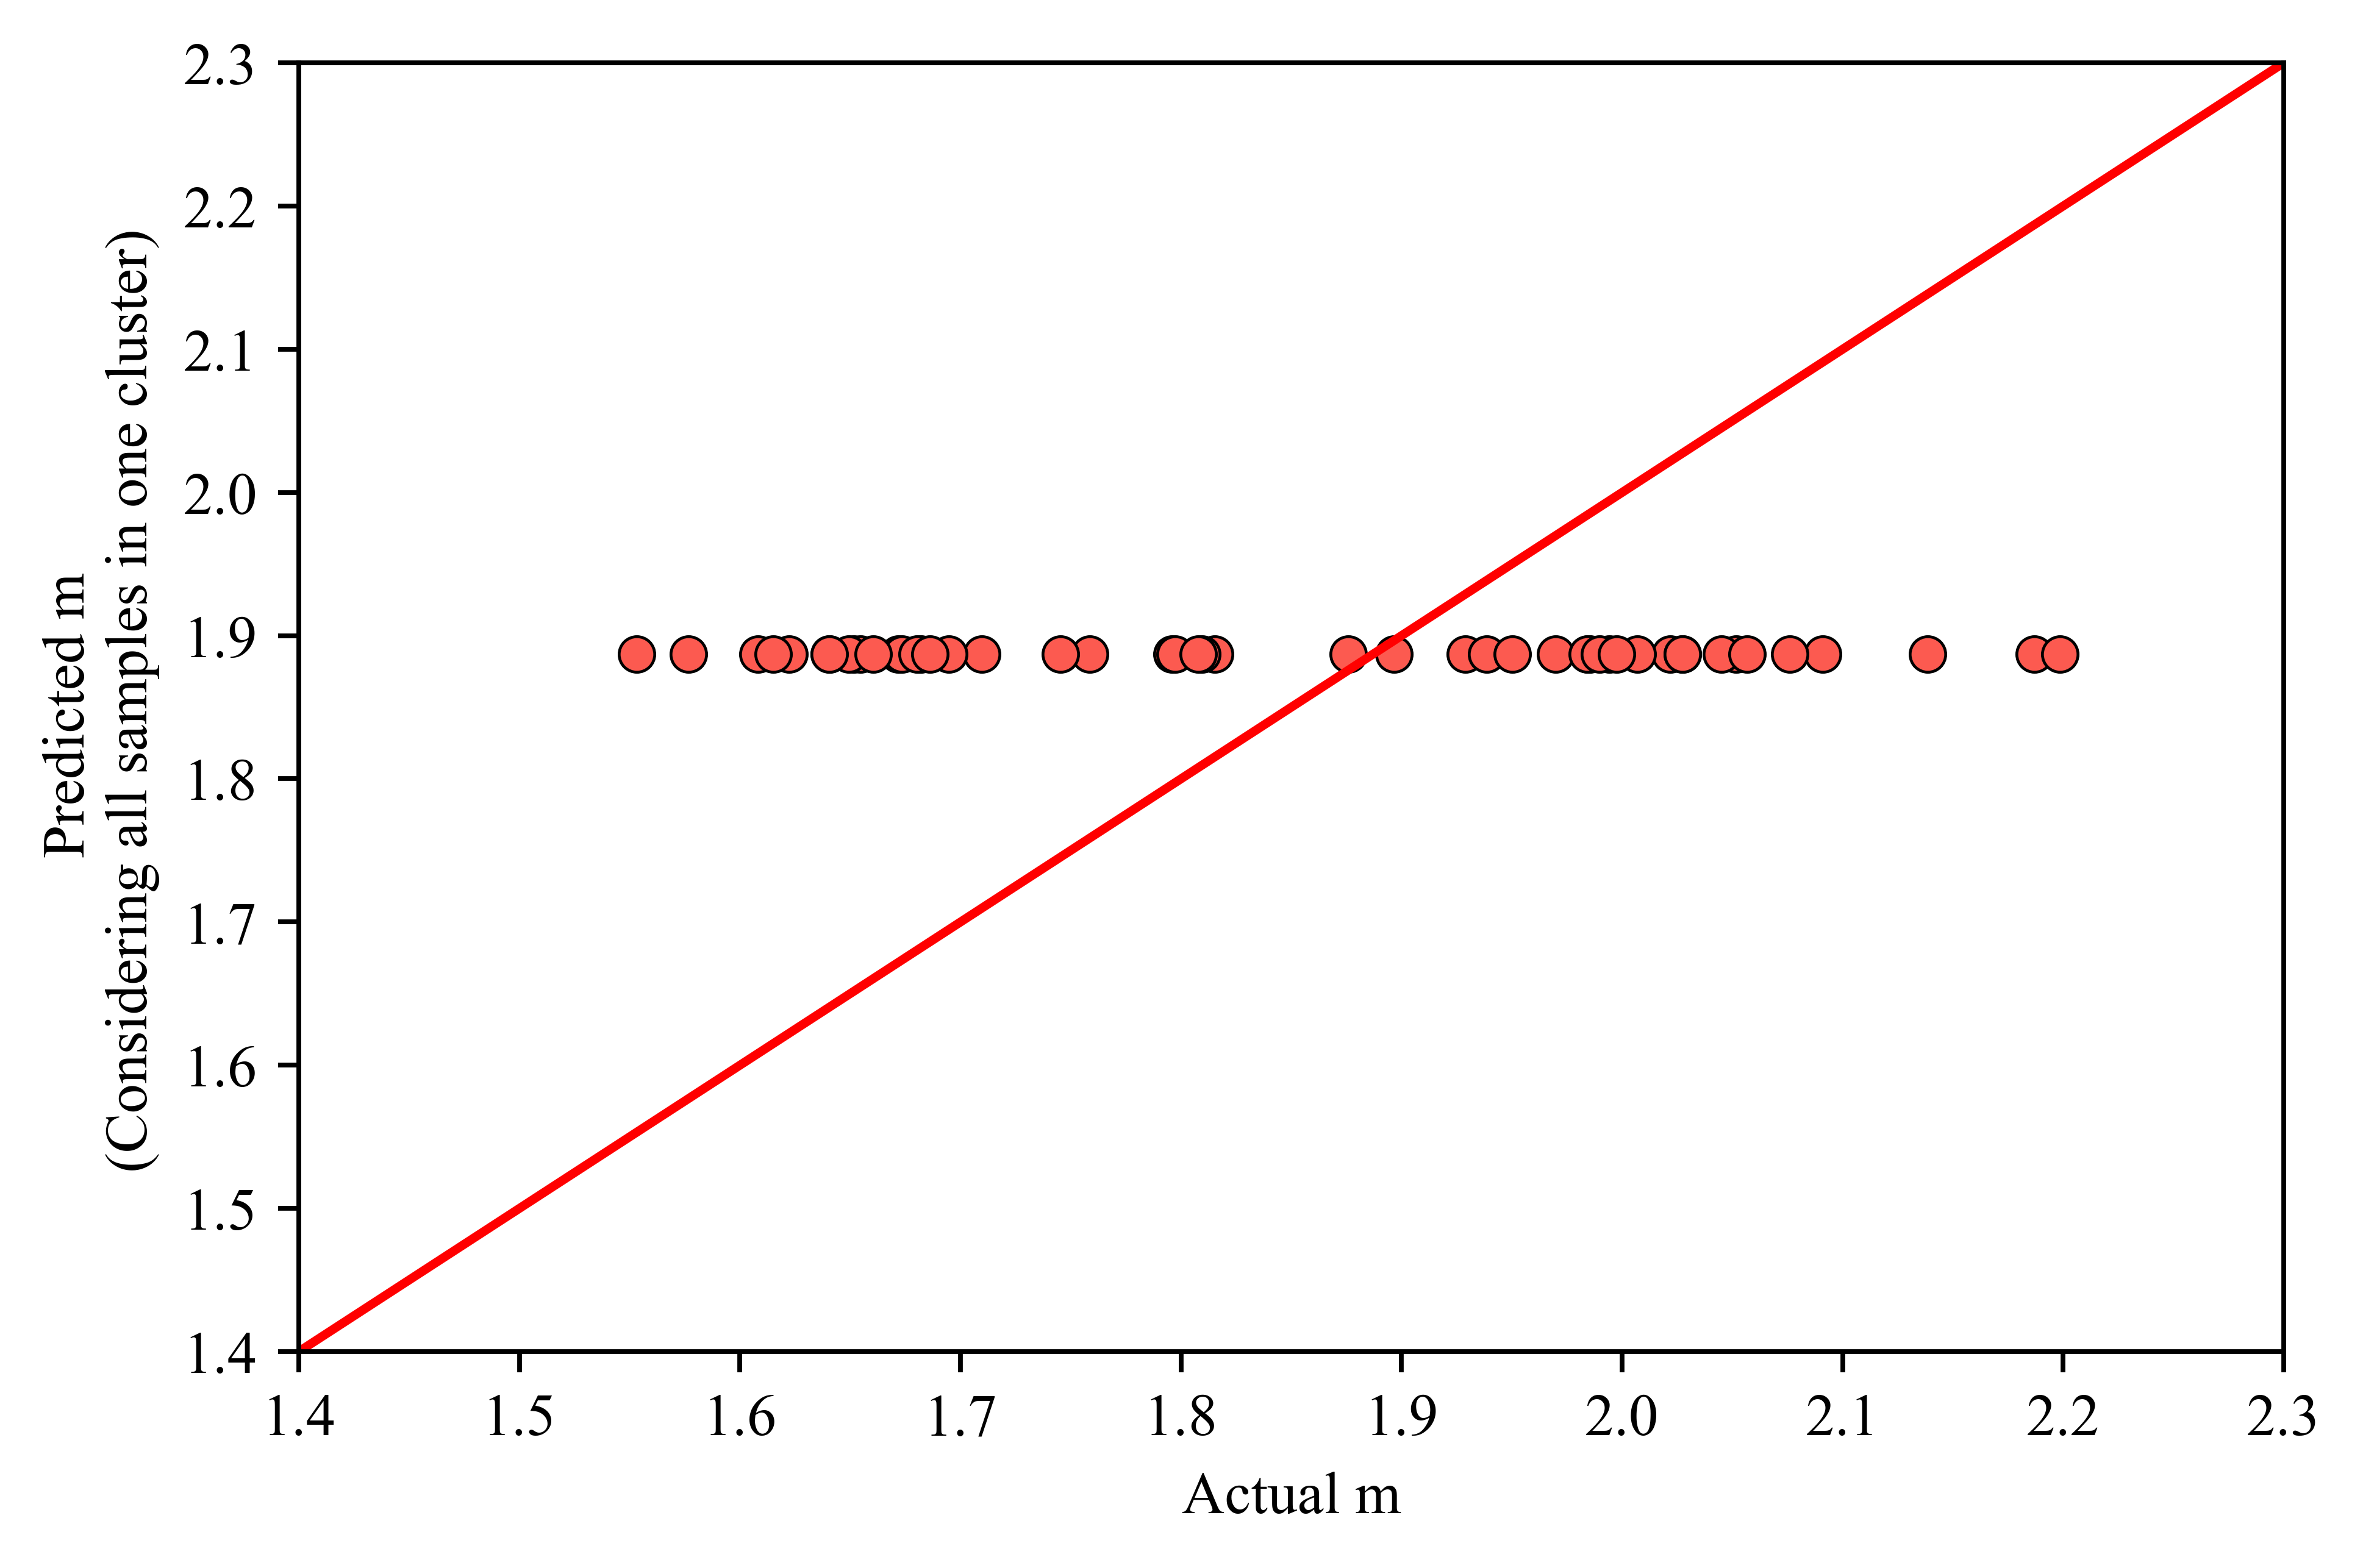

In [43]:
from sklearn.linear_model import LinearRegression
linear_model_results(test_df.mc, test_df.ma, '#FC5A50',1)

coefficient of determination: 0.0318383006010845
coef_: [[0.39296177]]
intercept: [1.0369608]


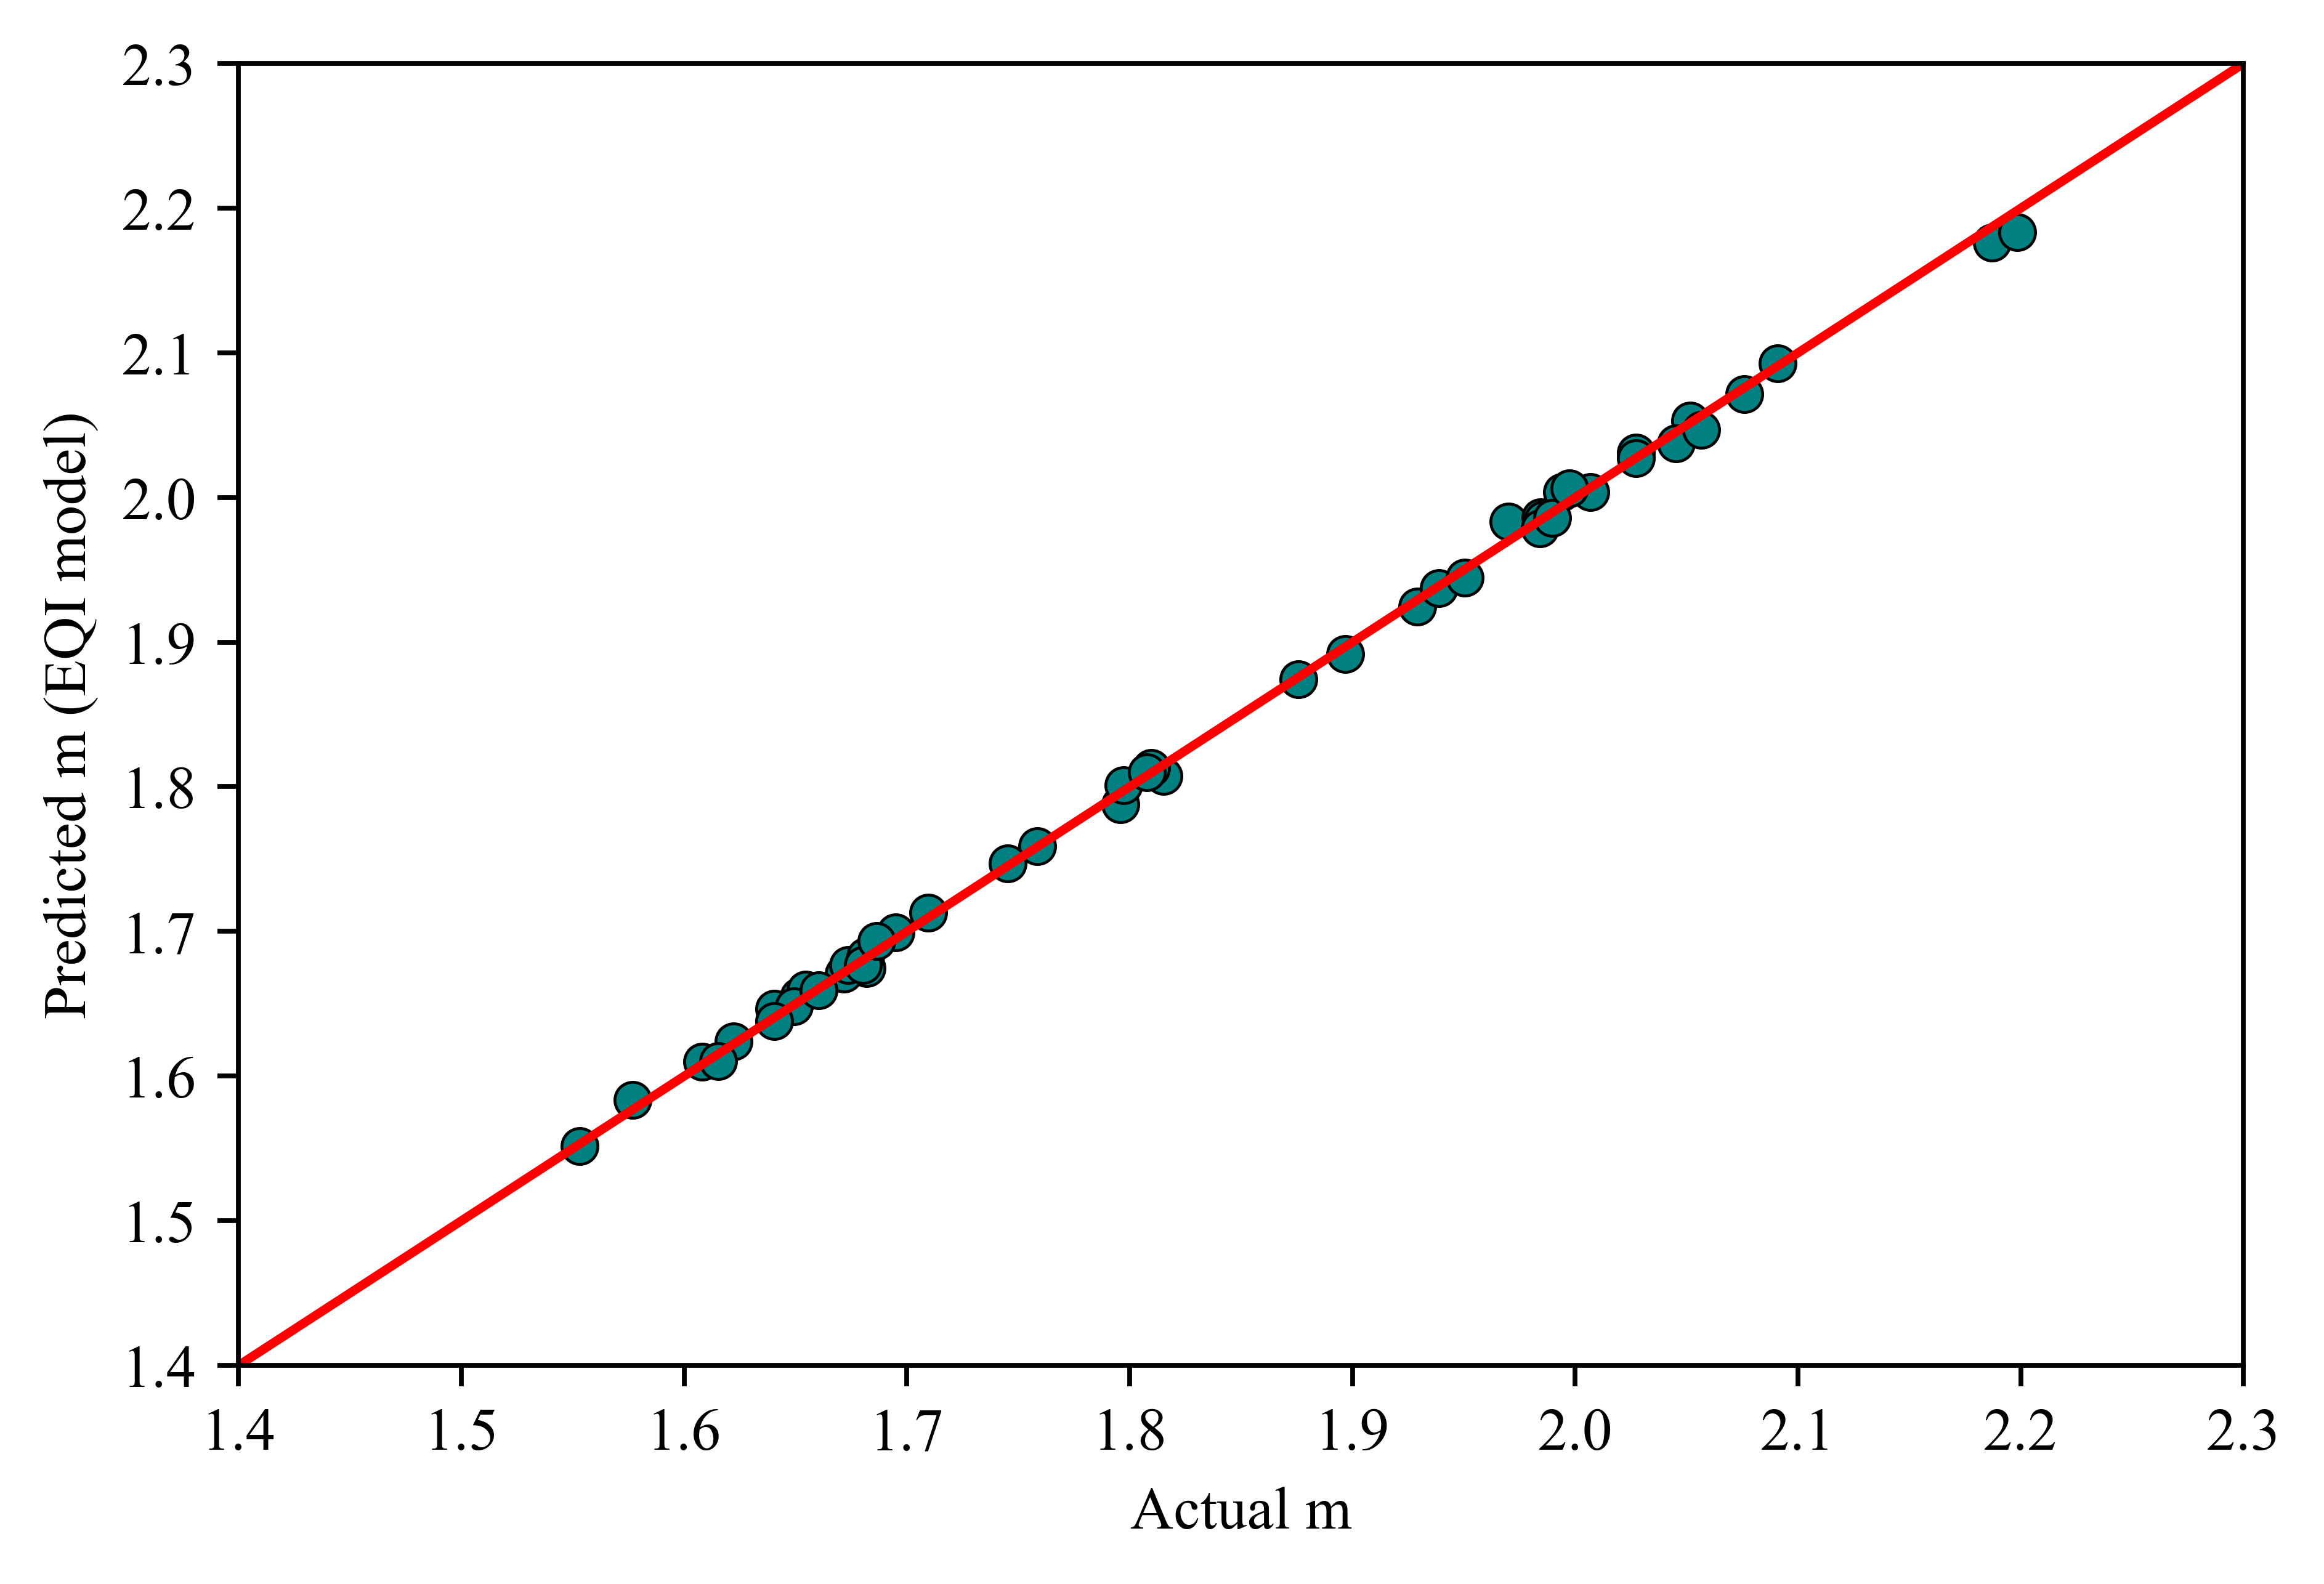

In [44]:
linear_model_results(test_df.mc, test_df.mp, '#008080',2)